<a href="https://colab.research.google.com/github/richardmukechiwa/Pnuemonia-Xray-ImageClassification/blob/main/PnuemoniaClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# checking libraries
#!pip list

In [2]:
!pip install torchinfo

# **Import Libraries**

In [3]:
import os

import numpy as np
import pandas as pd
from PIL import Image

from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix




import torch
from torchinfo import summary
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets
from torchvision import models
from torchvision.models import resnet18

# **Load Data**

In [4]:
# Check if GPU is available
if torch.cuda.is_available():
    device = 'cuda'

elif torch.backends.mps.is_available:
    device = 'mps'

else:
    device = 'cpu'

print(device)

cuda


In [5]:
# define data directories
train_path = ("/content/drive/MyDrive/chest_xray/train")
test_path = ("/content/drive/MyDrive/chest_xray/test")
val_path = ("/content/drive/MyDrive/chest_xray/val")


In [6]:
# get classes
classes = os.listdir(train_path)
print('There are', len(classes), 'classes')
print(classes)

There are 2 classes
['pneumonia', 'normal']


# **Data Exploration**

In [7]:
# converting images to RGB
class ConvertToRGB():
  def __call__(self, img):
    if img.mode != 'RGB':
      img = img.convert("RGB")
    return img

# defining transforms

transform = transforms.Compose(
    [
        ConvertToRGB(),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),


    ]
)


In [8]:
# creating  data sets using ImageFolder
train_dataset = datasets.ImageFolder(root = train_path, transform = transform)
val_dataset = datasets.ImageFolder(root = val_path, transform = transform)
test_dataset = datasets.ImageFolder(root = test_path, transform = transform) # to be used for testing

print(train_dataset)
print(val_dataset)

Dataset ImageFolder
    Number of datapoints: 3329
    Root location: /content/drive/MyDrive/chest_xray/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )
Dataset ImageFolder
    Number of datapoints: 20
    Root location: /content/drive/MyDrive/chest_xray/val
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )


In [9]:

#Total number datapoints in each dataset
print("Total train images", len(train_dataset))
print("Total val images", len(val_dataset))



Total train images 3329
Total val images 20


In [10]:
# Visualize a sample image
def image_label(dataset, i):
  image, label = dataset[i]
  0 <= i <= len(dataset)
  plt.imshow(image.permute(1, 2, 0))
  plt.title(f"Label: {label}")
  plt.show()


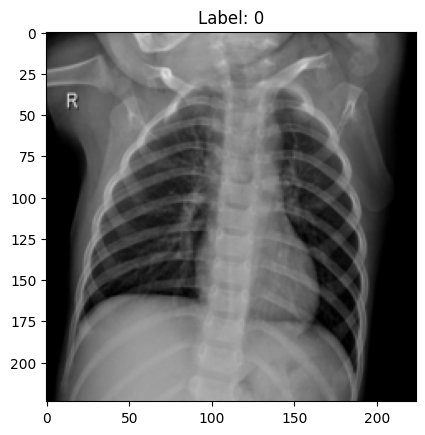

In [11]:
# using the function to get an image of the test dataset
image_label(val_dataset,7)

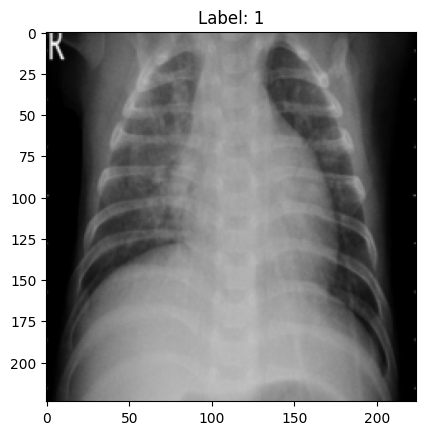

In [12]:
# using the function to get an image of the train dataset
image_label(train_dataset,1000)

In [13]:
# Classes balance verification

im = train_dataset.imgs
print(im[0])

distinct_classes = {x[1] for x in im}
print(distinct_classes)

('/content/drive/MyDrive/chest_xray/train/normal/IM-0115-0001 - Copy (2) - Copy - Copy.jpeg', 0)
{0, 1}


In [14]:
# class counts
from collections import Counter

def class_counts(dataset):
  c = Counter(x[1] for x in tqdm(dataset))
  class_to_index = dataset.class_to_idx
  return pd.Series({cat: c[idx]  for cat, idx in class_to_index.items()})


In [15]:
#class counts for train data
train_count = class_counts(train_dataset)
train_count

  0%|          | 0/3329 [00:00<?, ?it/s]

,0
normal,352
pneumonia,2977


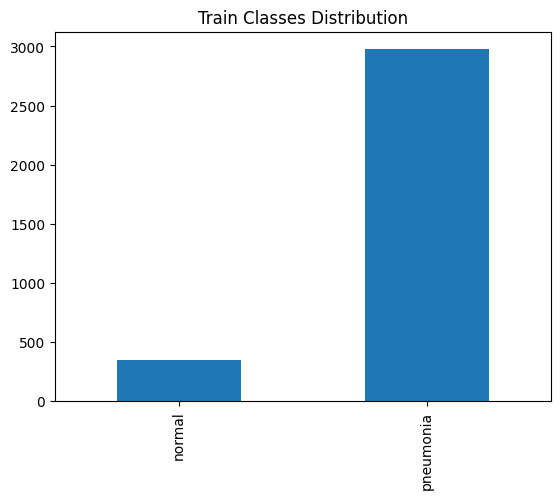

In [16]:
# plot the class counts
train_count.plot(kind = 'bar')
plt.title("Train Classes Distribution");

In [17]:
#class counts for validation data
val_count = class_counts(val_dataset)
val_count

  0%|          | 0/20 [00:00<?, ?it/s]

,0
normal,8
pneumonia,12


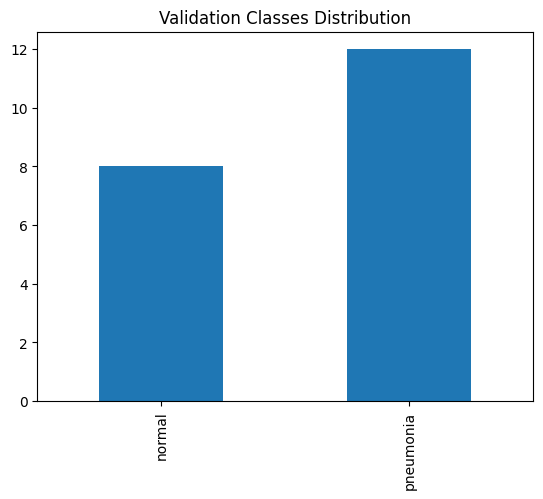

In [18]:
# plot the class counts
val_count.plot(kind = 'bar')
plt.title("Validation Classes Distribution");

In [19]:
#class counts for test data
test_count = class_counts(test_dataset)
test_count

  0%|          | 0/171 [00:00<?, ?it/s]

,0
normal,35
pneumonia,136


### **There is an imbalance in the datasets between the normal and pneumonia class**

I will use class weights to balance the train dataset

In [20]:
#normalizing the data using transforms

height = 224
width  =224

transform_norm = transforms.Compose(

     [
       ConvertToRGB(),
       transforms.Resize((width, height)),
       transforms.ToTensor(),
       transforms.transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

])


In [21]:
#creating a normalized dataset
train_dataset_norm = datasets.ImageFolder(root = train_path, transform = transform_norm)
val_dataset_norm = datasets.ImageFolder(root = val_path, transform = transform_norm)
test_dataset_norm = datasets.ImageFolder(test_path, transform = transform_norm) # to be used for training



In [22]:
# the shape of 1  image
train_dataset_norm[1][0].shape

torch.Size([3, 224, 224])

# **Model Development**

### **Transfer Learning**



In [23]:
# introducing a pretrained model
model = models.resnet18(weights= models.ResNet18_Weights.DEFAULT)
print(model)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 176MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [24]:
# freezing the parameters
for params in model.parameters():
    params.requires_grad = False
    print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [25]:
# replacing the last layer of the model

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 2),
    nn.Softmax(dim=1)
)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [26]:
# create a dataloaders
batch_size = 32

train_loader = DataLoader(train_dataset_norm, batch_size = batch_size, shuffle = True)
val_loader = DataLoader(val_dataset_norm, batch_size = batch_size, shuffle = False)


print(type(train_loader))
print(type(val_loader))


<class 'torch.utils.data.dataloader.DataLoader'>
<class 'torch.utils.data.dataloader.DataLoader'>


In [27]:
#batch shape
train_batch_size_shape = next(iter(train_loader))[0].shape
train_batch_size_shape

torch.Size([32, 3, 224, 224])

In [28]:
# class weights for training data  imbalances

#number of samples in a class
num_train_normal = 352
num_train_pneumonia = 2977

# add samples
total_samples = num_train_normal + num_train_pneumonia

#using inverse frequency to calculate weights
weight_for_normal = total_samples / (2* num_train_normal)
weight_for_pneumonia = total_samples / (2*num_train_pneumonia)


class_weights = torch.tensor([weight_for_normal, weight_for_pneumonia]).to(device) # to be using on the CrossEntropyLoss

print(weight_for_normal)
print(weight_for_pneumonia)
print(class_weights.device)

4.728693181818182
0.5591199193819281
cuda:0


In [29]:
# defining loss function and optimizer

loss_fn =   torch.nn.CrossEntropyLoss(weight =  class_weights) # class weights for imbalanced data
optimizer = torch.optim.Adam(model.parameters())

model.to(device)

print(loss_fn)
print('-' *20)
print(optimizer)
print('-'*20)
print(next(model.parameters()).device)


CrossEntropyLoss()
--------------------
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)
--------------------
cuda:0


## **Callbacks**

In [30]:
# Learning rate decay
step_size = 4
#multiplicative factor of learning rate decay
gamma = 0.2
#Learning rate scheduler
scheduler = StepLR(optimizer,
                   step_size = step_size,
                   gamma = gamma)
print(type(scheduler))

<class 'torch.optim.lr_scheduler.StepLR'>


In [31]:
# Early stopping

def early_stopping(val_Loss, best_val_Loss, counter):
    stop = False
    if val_Loss < best_val_Loss:
        counter = 0
    else:
            counter += 1

    if counter <= 12:
        stop = True

    return counter, stop


In [32]:
# checkpointing (checking if the validation loss improved)

def checkpointing(val_Loss, best_val_Loss, model, optimizer, save_path):
    if val_Loss < best_val_Loss:
        torch.save(
            {

                    "model_state_dict":  model.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "loss": best_val_Loss,




        },
                    save_path,
    )


    print(f"Checkpoiniting saved with the val Loss, {val_Loss:.4f}")


In [33]:
#training the model - resnet18
# training function

def train_model(model, train_loader, val_loader, loss_fn, optimizer, num_epochs, scheduler, early_stopping, checkpointing,   device = 'cpu' ):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print('-' * 10)

        # Iterate over training and validation phases
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                data_loader = train_loader
            else:
                model.eval()  # Set model to evaluation mode
                data_loader = val_loader

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in data_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = loss_fn(outputs, labels)

                    # Backward pass + optimization only in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(data_loader.dataset)
            epoch_acc = running_corrects.double() / len(data_loader.dataset)

            print(f'{phase}_Loss: {epoch_loss:.4f} {phase}_Acc: {epoch_acc:.4f}')



In [34]:
#train the model, model must be sent to device/GPU
num_epochs = 12
train_model(model, train_loader , val_loader, loss_fn, optimizer, num_epochs,scheduler, early_stopping, checkpointing, device = device )

Epoch 1/12
----------
train_Loss: 0.4272 train_Acc: 0.9360
val_Loss: 0.8817 val_Acc: 0.6500
Epoch 2/12
----------
train_Loss: 0.3363 train_Acc: 0.9982
val_Loss: 0.8867 val_Acc: 0.6500
Epoch 3/12
----------
train_Loss: 0.3254 train_Acc: 1.0000
val_Loss: 0.8998 val_Acc: 0.6500
Epoch 4/12
----------
train_Loss: 0.3217 train_Acc: 1.0000
val_Loss: 0.9616 val_Acc: 0.6500
Epoch 5/12
----------
train_Loss: 0.3193 train_Acc: 1.0000
val_Loss: 0.9701 val_Acc: 0.6500
Epoch 6/12
----------
train_Loss: 0.3173 train_Acc: 1.0000
val_Loss: 0.9658 val_Acc: 0.6500
Epoch 7/12
----------
train_Loss: 0.3167 train_Acc: 0.9997
val_Loss: 1.0167 val_Acc: 0.6500
Epoch 8/12
----------
train_Loss: 0.3155 train_Acc: 1.0000
val_Loss: 1.0112 val_Acc: 0.6500
Epoch 9/12
----------
train_Loss: 0.3155 train_Acc: 1.0000
val_Loss: 0.9684 val_Acc: 0.6500
Epoch 10/12
----------
train_Loss: 0.3152 train_Acc: 1.0000
val_Loss: 1.0205 val_Acc: 0.6500
Epoch 11/12
----------
train_Loss: 0.3148 train_Acc: 1.0000
val_Loss: 1.0175 va

## **Evaluation**

In [35]:
# using scikit learn metrics

from sklearn.metrics import accuracy_score, classification_report,  confusion_matrix, ConfusionMatrixDisplay


model.eval()
y_true, y_pred  =[], []
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs,1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

        accuracy  = accuracy_score(y_true, y_pred)

print(f'The model accuracy is', accuracy)



The model accuracy is 0.65


In [36]:
matrix = confusion_matrix(y_true, y_pred)
matrix

array([[ 1,  7],
       [ 0, 12]])

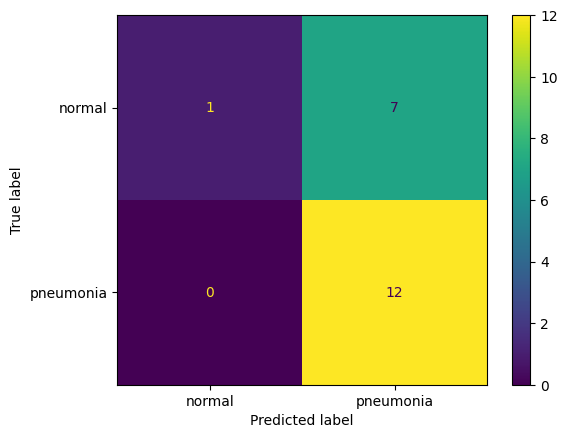

In [37]:
disp = ConfusionMatrixDisplay(matrix, display_labels = ['normal', 'pneumonia'])
disp.plot()
plt.show()

In [38]:
report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.12      0.22         8
           1       0.63      1.00      0.77        12

    accuracy                           0.65        20
   macro avg       0.82      0.56      0.50        20
weighted avg       0.78      0.65      0.55        20



In [39]:
#save the model
torch.save(model.state_dict(),"pneumonia_model.pth")


# **Classification on test data**

In [40]:
#Load the saved model

model = models.resnet18(weights = models.ResNet18_Weights.DEFAULT)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [41]:
# freezing the parameters
for params in model.parameters():
  params.requires_grad = False
  print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [42]:
#replacing the last layer of the model
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 2),
    torch.nn.Softmax(dim=1)
)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [43]:
#create a dataloader for the training dataset
test_loader = DataLoader(test_dataset_norm, batch_size = batch_size, shuffle = False)
test_loader

In [44]:
#load the model and evaluate the test data
model.load_state_dict(torch.load("pneumonia_model.pth", weights_only = True))

model.to(device)

model.eval()

y_true, y_pred  =[], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs,1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

        accuracy  = accuracy_score(y_true, y_pred)

print(f'The model accuracy on unseen data  is', accuracy)

The model accuracy on unseen data  is 0.9532163742690059


In [45]:
matrix_test = confusion_matrix(y_true, y_pred)
print(matrix_test)

[[ 35   0]
 [  8 128]]


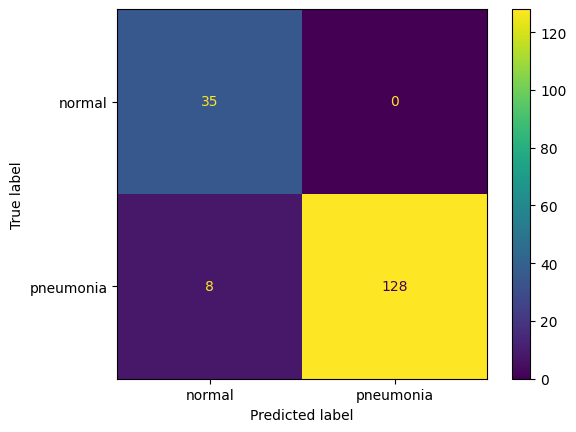

In [46]:
disp = ConfusionMatrixDisplay(matrix_test, display_labels = ['normal', 'pneumonia'])
disp.plot()

In [47]:
# 35 images were correctly predicted as "normal" out of 35 normal images
# 132 images were correctly predicted as having "pnuemonia" out of 136 pneumonia images

# **Testing a single image**

In [48]:
image = test_dataset_norm[17][0]
image_batch= image.unsqueeze(0)
image_batch.to(device)


tensor([[[[-1.8610, -1.7412, -1.6727,  ..., -1.6384, -1.7240, -1.8097],
          [-1.8439, -1.7583, -1.6555,  ..., -1.6555, -1.7240, -1.8097],
          [-1.8439, -1.7412, -1.6213,  ..., -1.6727, -1.7240, -1.8268],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

         [[-1.7731, -1.6506, -1.5805,  ..., -1.5455, -1.6331, -1.7206],
          [-1.7556, -1.6681, -1.5630,  ..., -1.5630, -1.6331, -1.7206],
          [-1.7556, -1.6506, -1.5280,  ..., -1.5805, -1.6331, -1.7381],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

         [[-1.5430, -1.4210, -1.3513,  ..., -1.3164, -1.4036, -1.4907],
          [-1.5256, -1.4384, -

In [49]:
#making inference
def test_prediction(model, dataset,i):
    image = dataset[i][0]
    image_batch= image.unsqueeze(0)

    model = model.to(device)

    with torch.no_grad():
        image_batch = image_batch.to(device)
        output = model(image_batch)
        _, predicted_class = output.max(1)

        # mapping the predcition to the class
        class_names = ['normal', 'pneumonia']

        # Map predictions to class names
        predicted_labels = [class_names[idx] for idx in predicted_class.cpu().numpy()]  # Convert to list of class names

          #Print results
    for idx, label in enumerate(predicted_labels):
        print(f"The predicted label for image {i + 1} is '{label}'.")

                # displaying the image
        image = np.transpose(image, (1, 2, 0))
        image = np.clip(image, 0, 1)
        plt.imshow(image)
        plt.axis('off')
        predicted_label = predicted_labels[0]
        plt.text(10, 20 , f'Predicted: {predicted_label}', fontsize = 15, color = "red", bbox=dict(facecolor='white', alpha=0.7))
        plt.show()

    #predicted_labels =class_names[predicted_class.item()]

    #print('The predicted label is ', predicted_labels)


The predicted label for image 18 is 'normal'.


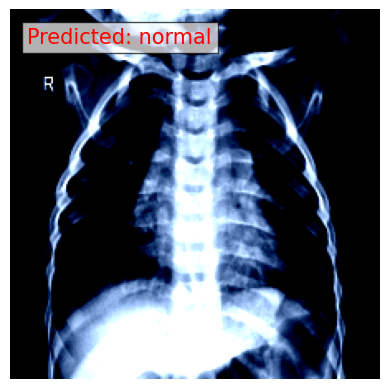

In [50]:
test_prediction(model, test_dataset_norm, 17)

In [52]:
from google.colab import files

# Download the file
files.download('pneumonia_model.pth')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>